## Import Data & Libraries

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')


#!pip install -U tensorflow==2.10
#!pip install -U tensorflow==2.9.2
import numpy as np
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split


!pip install transformers==4.37.2
#!pip install transformers==4.24
from transformers import (BertTokenizerFast, BertTokenizer, TFAutoModel,
                          TFBertForSequenceClassification, BertModel)
from transformers import TFBertModel
import IPython

#!pip install keras-tuner==1.0.4
!pip install keras-tuner
from keras_tuner.tuners import BayesianOptimization

import pickle
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import gensim.downloader

import matplotlib.pyplot as plt
import tensorflow as tf


Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 39.6 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.1
    Uninstalling transformers-4.41.1:
      Successfully uninstalled transformers-4.41.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
!gdown 16Vw8lUCX92-aEldl4XrVpjFX5CB6C8fL
!gdown 1JVvzn-M_OOuGmpDn94iNBj-x1mXzmBImtz1kaHZbSAI
!gdown 1ntOHso_y5bVBkAgJQDSizopozhYtTV1W

Downloading...
From: https://drive.google.com/uc?id=16Vw8lUCX92-aEldl4XrVpjFX5CB6C8fL
To: /content/file1.csv
100% 3.28M/3.28M [00:00<00:00, 137MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1JVvzn-M_OOuGmpDn94iNBj-x1mXzmBImtz1kaHZbSAI
From (redirected): https://docs.google.com/spreadsheets/d/1JVvzn-M_OOuGmpDn94iNBj-x1mXzmBImtz1kaHZbSAI/export?format=xlsx
To: /content/labeling.xlsx
624kB [00:00, 18.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ntOHso_y5bVBkAgJQDSizopozhYtTV1W
To: /content/test(1).csv
100% 290k/290k [00:00<00:00, 81.8MB/s]


In [ ]:
df_asli = pd.read_csv('/content/file1.csv', usecols=['content'])
df_train = pd.read_excel('/content/labeling.xlsx', usecols=['content', 'labeling'])
df_test = pd.read_csv('/content/test(1).csv', usecols=['content'])

In [ ]:
df_asli

,content
0,Aplikasi pengadu domba. Banyak yg menyalahguna...
1,Slm hormat.. knp pas loging BS masuk gt.padaha...
2,Baik sekali
3,Coba
4,Developer Aplikasi yg tidak bisa memberikan ke...
...,...
10793,Demi negara Indonesia🇮🇩 jaya
10794,Belum ada respon/ pengecekan usulan...katanya ...
10795,Terima 400 / bulan
10796,Petani


In [ ]:
df_train

,content,labeling
0,Saya sudah daftar dan ter verifikasi udh menga...,0
1,Aku kasih bintang 5 krn aku belum pernah meras...,0
2,Spesial tidak bisa masuk,0
3,Error Json Parse' padahal sudah update dan di ...,0
4,Negara +62 yg PNS nya digaji SDM nya ga punya ...,0
...,...,...
8633,"Saya sudah daftar , tapi belum di aktifasi..",0
8634,Ini aplikasi udah daftar tapi ga bisa masuk.. ...,0
8635,"Aplikasi sangat tidak mumpuni, pendaftaran ke ...",0
8636,ini kenapa aplikasinya gak bisa di buka ya min...,0


In [ ]:
df_test

,content
0,Tdak dapat login ke aplikasi cek basos meski s...
1,Saya sudah daftar dengan mengisi data2 yg sesu...
2,selalu loading
3,Alhmdulillah bisa masuk ke akun dan bisa usul ...
4,"Susah login, email aktivasi nya blm masuk2,pad..."
...,...
2155,"ga bisa login ""akun anda tidak di temukan /bel..."
2156,"Kenapa aplikasi erros terus, trus ditulisnya b..."
2157,sulit di buka
2158,"Pendaftaran sangat di persulit, Data saya suda..."


## Preprocessing

In [ ]:
def preProcessing1(tweet):
    # Convert to lower case
    tweet = tweet.lower()
    # remove unicode characters
    tweet = tweet.encode('ascii', 'ignore').decode()
    # Clean www.* or https?://*
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    # Clean @username
    tweet = re.sub('@[^\s]+','',tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #trim
    tweet = tweet.strip('\'"')

    return tweet


_stopwords1 = set(stopwords.words('indonesian'))
_stopwrods2 = set(stopwords.words('english'))
additional_stopwords1 = ['saya', 'nya', 'saat',
                        'sih', 'deh', 'dll', 'nih', 'donk',
                        'dong', 'min', 'ny', 'si', 'eh', 'tu',
                        'mah', 'loh', 'aja', 'cm', 'blh', 'gt',
                         'knp', 'yg']
additional_stopwords2 = ['the', 'a', 'an', 'or', 'in']
new_stopwords = stopwords.words('indonesian') + additional_stopwords1 + additional_stopwords2 + stopwords.words('english')

def preProcessing2(text):
  # menghilangkan angka
  text = re.sub(r"\d+", "", text)
  # menghilangkan karakter spesial lain
  text = re.sub(r'[^\w\s]','',text)

  # tokenisasi
  tokens = re.findall(r'\b\w+\b', text)
  # menghilangkan stopword
  tokens = [token for token in tokens if token not in new_stopwords]

  # menggabungkan token
  text = ' '.join(tokens)

  return text


## Preprocessing 1

In [ ]:
def cleaning1(dataset):
  dataset['content_cleaned'] = dataset['content'].map(lambda x: preProcessing1(x))
  dataset = dataset[dataset['content_cleaned'].apply(lambda x: len(x.split()) >= 3)].reset_index(drop=True)
  return dataset

In [ ]:
df_asli = cleaning1(df_asli)
df_train = cleaning1(df_train)
df_test = cleaning1(df_test)

In [ ]:
df_train

,content,labeling,content_cleaned
0,Saya sudah daftar dan ter verifikasi udh menga...,0,saya sudah daftar dan ter verifikasi udh menga...
1,Aku kasih bintang 5 krn aku belum pernah meras...,0,aku kasih bintang 5 krn aku belum pernah meras...
2,Spesial tidak bisa masuk,0,spesial tidak bisa masuk
3,Error Json Parse' padahal sudah update dan di ...,0,error json parse' padahal sudah update dan di ...
4,Negara +62 yg PNS nya digaji SDM nya ga punya ...,0,negara +62 yg pns nya digaji sdm nya ga punya ...
...,...,...,...
7564,"Saya sudah daftar , tapi belum di aktifasi..",0,"saya sudah daftar , tapi belum di aktifasi.."
7565,Ini aplikasi udah daftar tapi ga bisa masuk.. ...,0,ini aplikasi udah daftar tapi ga bisa masuk.. ...
7566,"Aplikasi sangat tidak mumpuni, pendaftaran ke ...",0,"aplikasi sangat tidak mumpuni, pendaftaran ke ..."
7567,ini kenapa aplikasinya gak bisa di buka ya min...,0,ini kenapa aplikasinya gak bisa di buka ya min...


In [ ]:
df_asli

,content,content_cleaned
0,Aplikasi pengadu domba. Banyak yg menyalahguna...,aplikasi pengadu domba. banyak yg menyalahguna...
1,Slm hormat.. knp pas loging BS masuk gt.padaha...,slm hormat.. knp pas loging bs masuk gt.padaha...
2,Developer Aplikasi yg tidak bisa memberikan ke...,developer aplikasi yg tidak bisa memberikan ke...
3,Responnya lama aku daftar dari 2020 kirain uda...,responnya lama aku daftar dari 2020 kirain uda...
4,"Sudah daftar,tapi kenapa saya masukan username...","sudah daftar,tapi kenapa saya masukan username..."
...,...,...
9450,Alhamdulillah sudah bisa login setelah menungg...,alhamdulillah sudah bisa login setelah menungg...
9451,Coba dulu app nya ..,coba dulu app nya ..
9452,Demi negara Indonesia🇮🇩 jaya,demi negara indonesia jaya
9453,Belum ada respon/ pengecekan usulan...katanya ...,belum ada respon/ pengecekan usulan...katanya ...


In [ ]:
df_test

,content,content_cleaned
0,Tdak dapat login ke aplikasi cek basos meski s...,tdak dapat login ke aplikasi cek basos meski s...
1,Saya sudah daftar dengan mengisi data2 yg sesu...,saya sudah daftar dengan mengisi data2 yg sesu...
2,Alhmdulillah bisa masuk ke akun dan bisa usul ...,alhmdulillah bisa masuk ke akun dan bisa usul ...
3,"Susah login, email aktivasi nya blm masuk2,pad...","susah login, email aktivasi nya blm masuk2,pad..."
4,Saya kasih bintang full langsung sebagai apres...,saya kasih bintang full langsung sebagai apres...
...,...,...
1881,"ga bisa login ""akun anda tidak di temukan /bel...","ga bisa login ""akun anda tidak di temukan /bel..."
1882,"Kenapa aplikasi erros terus, trus ditulisnya b...","kenapa aplikasi erros terus, trus ditulisnya b..."
1883,sulit di buka,sulit di buka
1884,"Pendaftaran sangat di persulit, Data saya suda...","pendaftaran sangat di persulit, data saya suda..."


## Representasi BERT

In [ ]:
from tensorflow import keras
from transformers import AutoTokenizer, TFAutoModel
import IPython

bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
def tokenisasi(teks):
    encode_dict = bert_tokenizer(teks,
                                   add_special_tokens = True,
                                   max_length = 128,
                                   padding = 'max_length',
                                   truncation = True,
                                   return_attention_mask = True,
                                   return_tensors = 'tf',)

    tokenID = encode_dict['input_ids']
    attention_mask = encode_dict['attention_mask']

    return tokenID, attention_mask

def create_input(data):
    tokenID, input_mask = [], []
    for teks in data:
        token, mask = tokenisasi(teks)
        tokenID.append(token)
        input_mask.append(mask)

    return [np.asarray(tokenID, dtype=np.int32).reshape(-1, 128),
            np.asarray(input_mask, dtype=np.int32).reshape(-1, 128)]

bert_model = TFAutoModel.from_pretrained("bert-base-multilingual-cased", trainable=False)
def bert(hp):

    #Input layer
    input_token = keras.layers.Input(shape=(128,), dtype=np.int32,
                                        name="input_token")
    input_mask = keras.layers.Input(shape=(128,), dtype=np.int32,
                                   name="input_mask")

    #Embedding
    bert_embedding = bert_model([input_token, input_mask])[0]

    #Output layer
    output = keras.layers.Dense(1, activation='sigmoid',
                                kernel_regularizer=keras.regularizers.l2(hp.Choice('kernel_dense', values = [0.01, 0.001])))(bert_embedding)

    model = keras.models.Model(inputs=[input_token, input_mask], outputs=output)

    model.compile(optimizer = keras.optimizers.Adam(1e-3),
                  loss ='binary_crossentropy',
                  metrics=['accuracy'])

    return model

class ClearTrainingOutput(keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(
    df_train['content_cleaned'], df_train['labeling'], test_size=0.2, random_state=42)

bert_train_data = create_input(train_data)
bert_test_data = create_input(test_data)

In [ ]:
from keras_tuner.tuners import BayesianOptimization


tuner = BayesianOptimization(bert,
                             objective = 'val_accuracy',
                             max_trials = 10,
                             directory = '/content/drive/MyDrive/Dataset TK2',
                             project_name = 'Sentiment-BERT',
                             overwrite = True)

tuner.search(bert_train_data, train_labels,
             batch_size=256, epochs=50,
             validation_data=(bert_test_data, test_labels),
             callbacks=[early_stop, ClearTrainingOutput()])

Trial 2 Complete [01h 01m 45s]
val_accuracy: 0.8423309326171875

Best val_accuracy So Far: 0.8423309326171875
Total elapsed time: 01h 57m 55s


In [ ]:
#model terbaik
model = tuner.get_best_models()[0]

In [ ]:
test_loss, test_acc = model.evaluate(bert_test_data, test_labels)
print('Test accuracy:', test_acc)

48/48 [==============================] - 25s 262ms/step - loss: 0.3798 - accuracy: 0.8423
Test accuracy: 0.8423309326171875


In [ ]:
#saving model
model.save('/content/drive/MyDrive/Dataset TK2/model_mlp_sentiment.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
keras.utils.get_custom_objects()['TFBertModel'] = TFBertModel
model = keras.models.load_model('/content/drive/MyDrive/Dataset TK2/model_mlp_sentiment.h5')

In [ ]:
predictions = model.predict(bert_test_data)
predictions

48/48 [==============================] - 711s 15s/step


array([[[0.0268274 ],
        [0.02956254],
        [0.01574222],
        ...,
        [0.00561315],
        [0.00947643],
        [0.0060453 ]],

       [[0.24477473],
        [0.4595669 ],
        [0.3380826 ],
        ...,
        [0.21238057],
        [0.2195113 ],
        [0.24366319]],

       [[0.15583764],
        [0.04985011],
        [0.04082455],
        ...,
        [0.12244081],
        [0.11443979],
        [0.12173056]],

       ...,

       [[0.21599963],
        [0.25403872],
        [0.18256976],
        ...,
        [0.23084307],
        [0.24697496],
        [0.24608266]],

       [[0.11364303],
        [0.06803549],
        [0.18773475],
        ...,
        [0.10697057],
        [0.14277218],
        [0.13013166]],

       [[0.3896974 ],
        [0.36760515],
        [0.32152954],
        ...,
        [0.25925848],
        [0.2855656 ],
        [0.24977417]]], dtype=float32)

In [ ]:
predicted_label = [1 if pred[0]>= 0.5 else 0 for pred in predictions]

predict = pd.DataFrame(test_labels.copy())
predict['predicted'] = predicted_label
predict

,labeling,predicted
7387,0,0
1277,1,0
2312,0,0
586,1,0
6609,0,0
...,...,...
6704,0,0
5893,0,0
347,1,0
6682,0,0


## Evaluasi Model

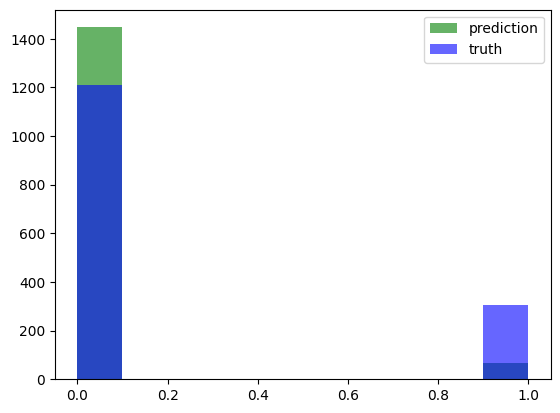

In [ ]:
plt.hist(predict['predicted'], color='green', alpha=.6)
plt.hist(predict['labeling'], color='blue', alpha=.6)
plt.legend(['prediction', 'truth'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import metrics

# showing confusion matrix
def evaluation_parametrics(name, y_val, y_pred):

    print("\n------------------------{}------------------------\n".format(name))

    cm_test = confusion_matrix(y_val, y_pred)
    t1 = ConfusionMatrixDisplay(cm_test)
    print("\nClassification Report for Data Test\n")
    print(classification_report(y_val, y_pred))
    print("--------------------------------------------------------------------------")

    t1.plot()


------------------------BERT-NN Sentiment Analysis Model------------------------


Classification Report for Data Test

              precision    recall  f1-score   support

           0       0.83      0.99      0.90      1210
           1       0.85      0.19      0.31       304

    accuracy                           0.83      1514
   macro avg       0.84      0.59      0.61      1514
weighted avg       0.83      0.83      0.78      1514

--------------------------------------------------------------------------


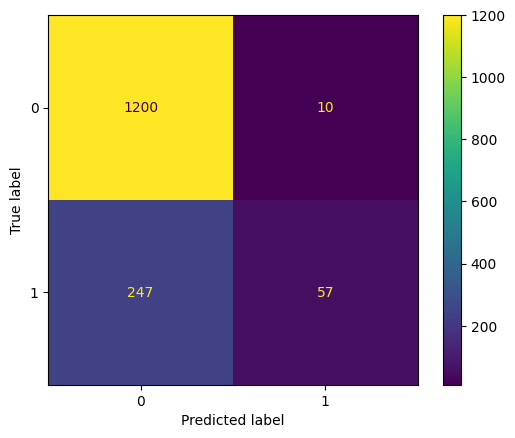

In [ ]:
evaluation_parametrics('BERT-NN Sentiment Analysis Model', predict['labeling'], predict['predicted'])

## Pengaplikasian Model

In [ ]:
df_test

,content,content_cleaned
0,Tdak dapat login ke aplikasi cek basos meski s...,tdak dapat login ke aplikasi cek basos meski s...
1,Saya sudah daftar dengan mengisi data2 yg sesu...,saya sudah daftar dengan mengisi data2 yg sesu...
2,Alhmdulillah bisa masuk ke akun dan bisa usul ...,alhmdulillah bisa masuk ke akun dan bisa usul ...
3,"Susah login, email aktivasi nya blm masuk2,pad...","susah login, email aktivasi nya blm masuk2,pad..."
4,Saya kasih bintang full langsung sebagai apres...,saya kasih bintang full langsung sebagai apres...
...,...,...
1881,"ga bisa login ""akun anda tidak di temukan /bel...","ga bisa login ""akun anda tidak di temukan /bel..."
1882,"Kenapa aplikasi erros terus, trus ditulisnya b...","kenapa aplikasi erros terus, trus ditulisnya b..."
1883,sulit di buka,sulit di buka
1884,"Pendaftaran sangat di persulit, Data saya suda...","pendaftaran sangat di persulit, data saya suda..."


In [ ]:
data_prediksi = create_input(df_test['content_cleaned'])
data_prediksi

[array([[  101,   188, 37052, ...,     0,     0,     0],
        [  101, 64981, 25147, ..., 31915, 86108,   102],
        [  101, 10164, 29389, ...,     0,     0,     0],
        ...,
        [  101, 12037, 10486, ...,     0,     0,     0],
        [  101, 66558, 10229, ...,     0,     0,     0],
        [  101, 25147, 12718, ...,     0,     0,     0]], dtype=int32),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)]

In [ ]:
prediksi_asli = model.predict(data_prediksi)
prediksi_asli

59/59 [==============================] - 16s 272ms/step


array([[[0.18452471],
        [0.3700232 ],
        [0.19905266],
        ...,
        [0.1298761 ],
        [0.14292663],
        [0.1905214 ]],

       [[0.1973003 ],
        [0.20935135],
        [0.32550466],
        ...,
        [0.19487636],
        [0.17313935],
        [0.2297944 ]],

       [[0.22719933],
        [0.22429831],
        [0.3420375 ],
        ...,
        [0.08781528],
        [0.08318038],
        [0.08776921]],

       ...,

       [[0.4564563 ],
        [0.8651116 ],
        [0.80214417],
        ...,
        [0.7150462 ],
        [0.72066057],
        [0.7170492 ]],

       [[0.23901108],
        [0.14515822],
        [0.27597982],
        ...,
        [0.22321984],
        [0.2666558 ],
        [0.19708586]],

       [[0.07065356],
        [0.03611123],
        [0.03379207],
        ...,
        [0.0239871 ],
        [0.019109  ],
        [0.01892799]]], dtype=float32)

In [ ]:
hasil_prediksi = [1 if pred[1]>= 0.5 else 0 for pred in prediksi_asli]

In [ ]:
data_prediksi = df_train.drop(['content_cleaned'], axis=1)
data_prediksi

,content,labeling
0,Saya sudah daftar dan ter verifikasi udh menga...,0
1,Aku kasih bintang 5 krn aku belum pernah meras...,0
2,Spesial tidak bisa masuk,0
3,Error Json Parse' padahal sudah update dan di ...,0
4,Negara +62 yg PNS nya digaji SDM nya ga punya ...,0
...,...,...
7564,"Saya sudah daftar , tapi belum di aktifasi..",0
7565,Ini aplikasi udah daftar tapi ga bisa masuk.. ...,0
7566,"Aplikasi sangat tidak mumpuni, pendaftaran ke ...",0
7567,ini kenapa aplikasinya gak bisa di buka ya min...,0


In [ ]:
data_unlabeled = df_test.drop(['content_cleaned'], axis=1)
data_unlabeled['labeling'] = hasil_prediksi
data_unlabeled

,content,labeling
0,Tdak dapat login ke aplikasi cek basos meski s...,0
1,Saya sudah daftar dengan mengisi data2 yg sesu...,0
2,Alhmdulillah bisa masuk ke akun dan bisa usul ...,0
3,"Susah login, email aktivasi nya blm masuk2,pad...",0
4,Saya kasih bintang full langsung sebagai apres...,1
...,...,...
1881,"ga bisa login ""akun anda tidak di temukan /bel...",0
1882,"Kenapa aplikasi erros terus, trus ditulisnya b...",0
1883,sulit di buka,1
1884,"Pendaftaran sangat di persulit, Data saya suda...",0


In [ ]:
hasil_akhir = pd.concat([data_prediksi, data_unlabeled], axis=0).reset_index(drop=True)
hasil_akhir

,content,labeling
0,Saya sudah daftar dan ter verifikasi udh menga...,0
1,Aku kasih bintang 5 krn aku belum pernah meras...,0
2,Spesial tidak bisa masuk,0
3,Error Json Parse' padahal sudah update dan di ...,0
4,Negara +62 yg PNS nya digaji SDM nya ga punya ...,0
...,...,...
9450,"ga bisa login ""akun anda tidak di temukan /bel...",0
9451,"Kenapa aplikasi erros terus, trus ditulisnya b...",0
9452,sulit di buka,1
9453,"Pendaftaran sangat di persulit, Data saya suda...",0


In [ ]:
hasil_akhir.to_csv('/content/drive/MyDrive/Dataset TK2/hasil_sentimen.csv')

In [ ]:
hasil_akhir = pd.read_csv('/content/drive/MyDrive/Dataset TK2/hasil_sentimen.csv', index_col=0)
hasil_akhir

,content,labeling
0,Saya sudah daftar dan ter verifikasi udh menga...,0
1,Aku kasih bintang 5 krn aku belum pernah meras...,0
2,Spesial tidak bisa masuk,0
3,Error Json Parse' padahal sudah update dan di ...,0
4,Negara +62 yg PNS nya digaji SDM nya ga punya ...,0
...,...,...
9450,"ga bisa login ""akun anda tidak di temukan /bel...",0
9451,"Kenapa aplikasi erros terus, trus ditulisnya b...",0
9452,sulit di buka,1
9453,"Pendaftaran sangat di persulit, Data saya suda...",0


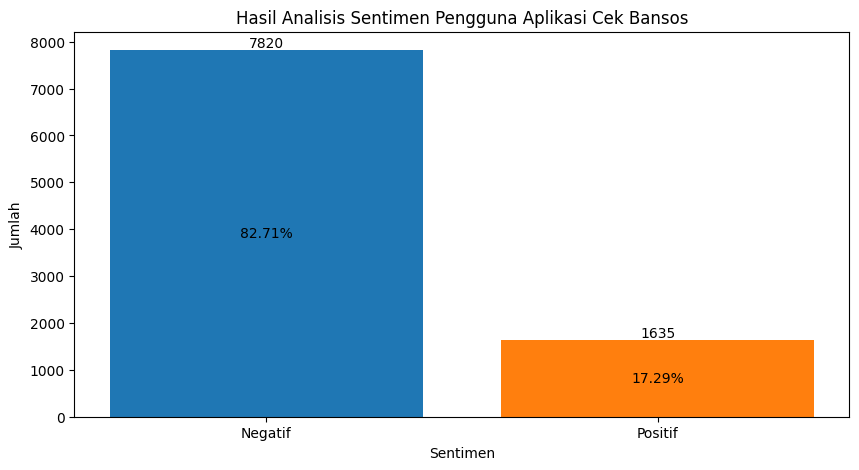

In [ ]:
sentimen = ['Negatif', 'Positif']
nilai = [i for i in hasil_akhir['labeling'].value_counts()]

plt.figure(figsize=(10, 5))

plt.bar(sentimen, nilai, color=['tab:blue','tab:orange'])

# Menambahkan label dan judul
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.title('Hasil Analisis Sentimen Pengguna Aplikasi Cek Bansos')

# Menambahkan nilai di atas setiap batang
for i, value in enumerate(nilai):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom')
    plt.text(i, value/2, str(round(value/sum(nilai)*100,2))+'%', ha='center', va='center')

# Menampilkan plot
plt.show()


# Menambahkan label dan judul
#plt.xlabel('Sentimen')
#plt.ylabel('Jumlah')
#plt.title('Hasil Analisis Sentimen Pengguna Aplikasi Cek Bansos')

# Menampilkan plot
#plt.show()

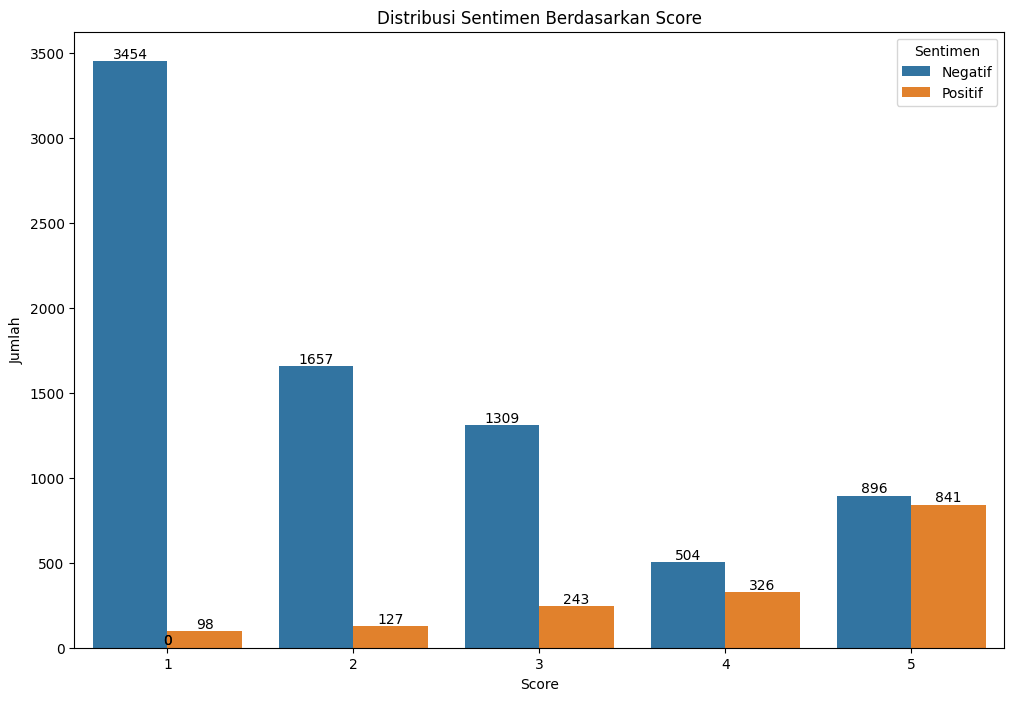

In [2]:
import seaborn as sns

# Membaca dataset dengan benar
hasil_sentimen_berdasarkan_rating = pd.read_csv('/content/drive/MyDrive/Dataset TK2/hasil_sentimen_berdasarkan_score-2.csv')

# Membuat plot batang untuk distribusi sentimen berdasarkan score
plt.figure(figsize=(12, 8))
sns.countplot(data=hasil_sentimen_berdasarkan_rating, x='score', hue='labeling', palette=['tab:blue', 'tab:orange'])

# Menambahkan label dan judul
plt.xlabel('Score')
plt.ylabel('Jumlah')
plt.title('Distribusi Sentimen Berdasarkan Score')
plt.legend(title='Sentimen', loc='upper right', labels=['Negatif', 'Positif'])

# Menambahkan nilai di atas setiap batang
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 0.1, int(height), ha='center', va='bottom')

# Menampilkan plot
plt.show()